number of anchor in total = 9332
Most concentrated features pixel has 76.0 anchors
Total anchor in heatmap = 9332.0
There are 434 pixel that don't have anchors


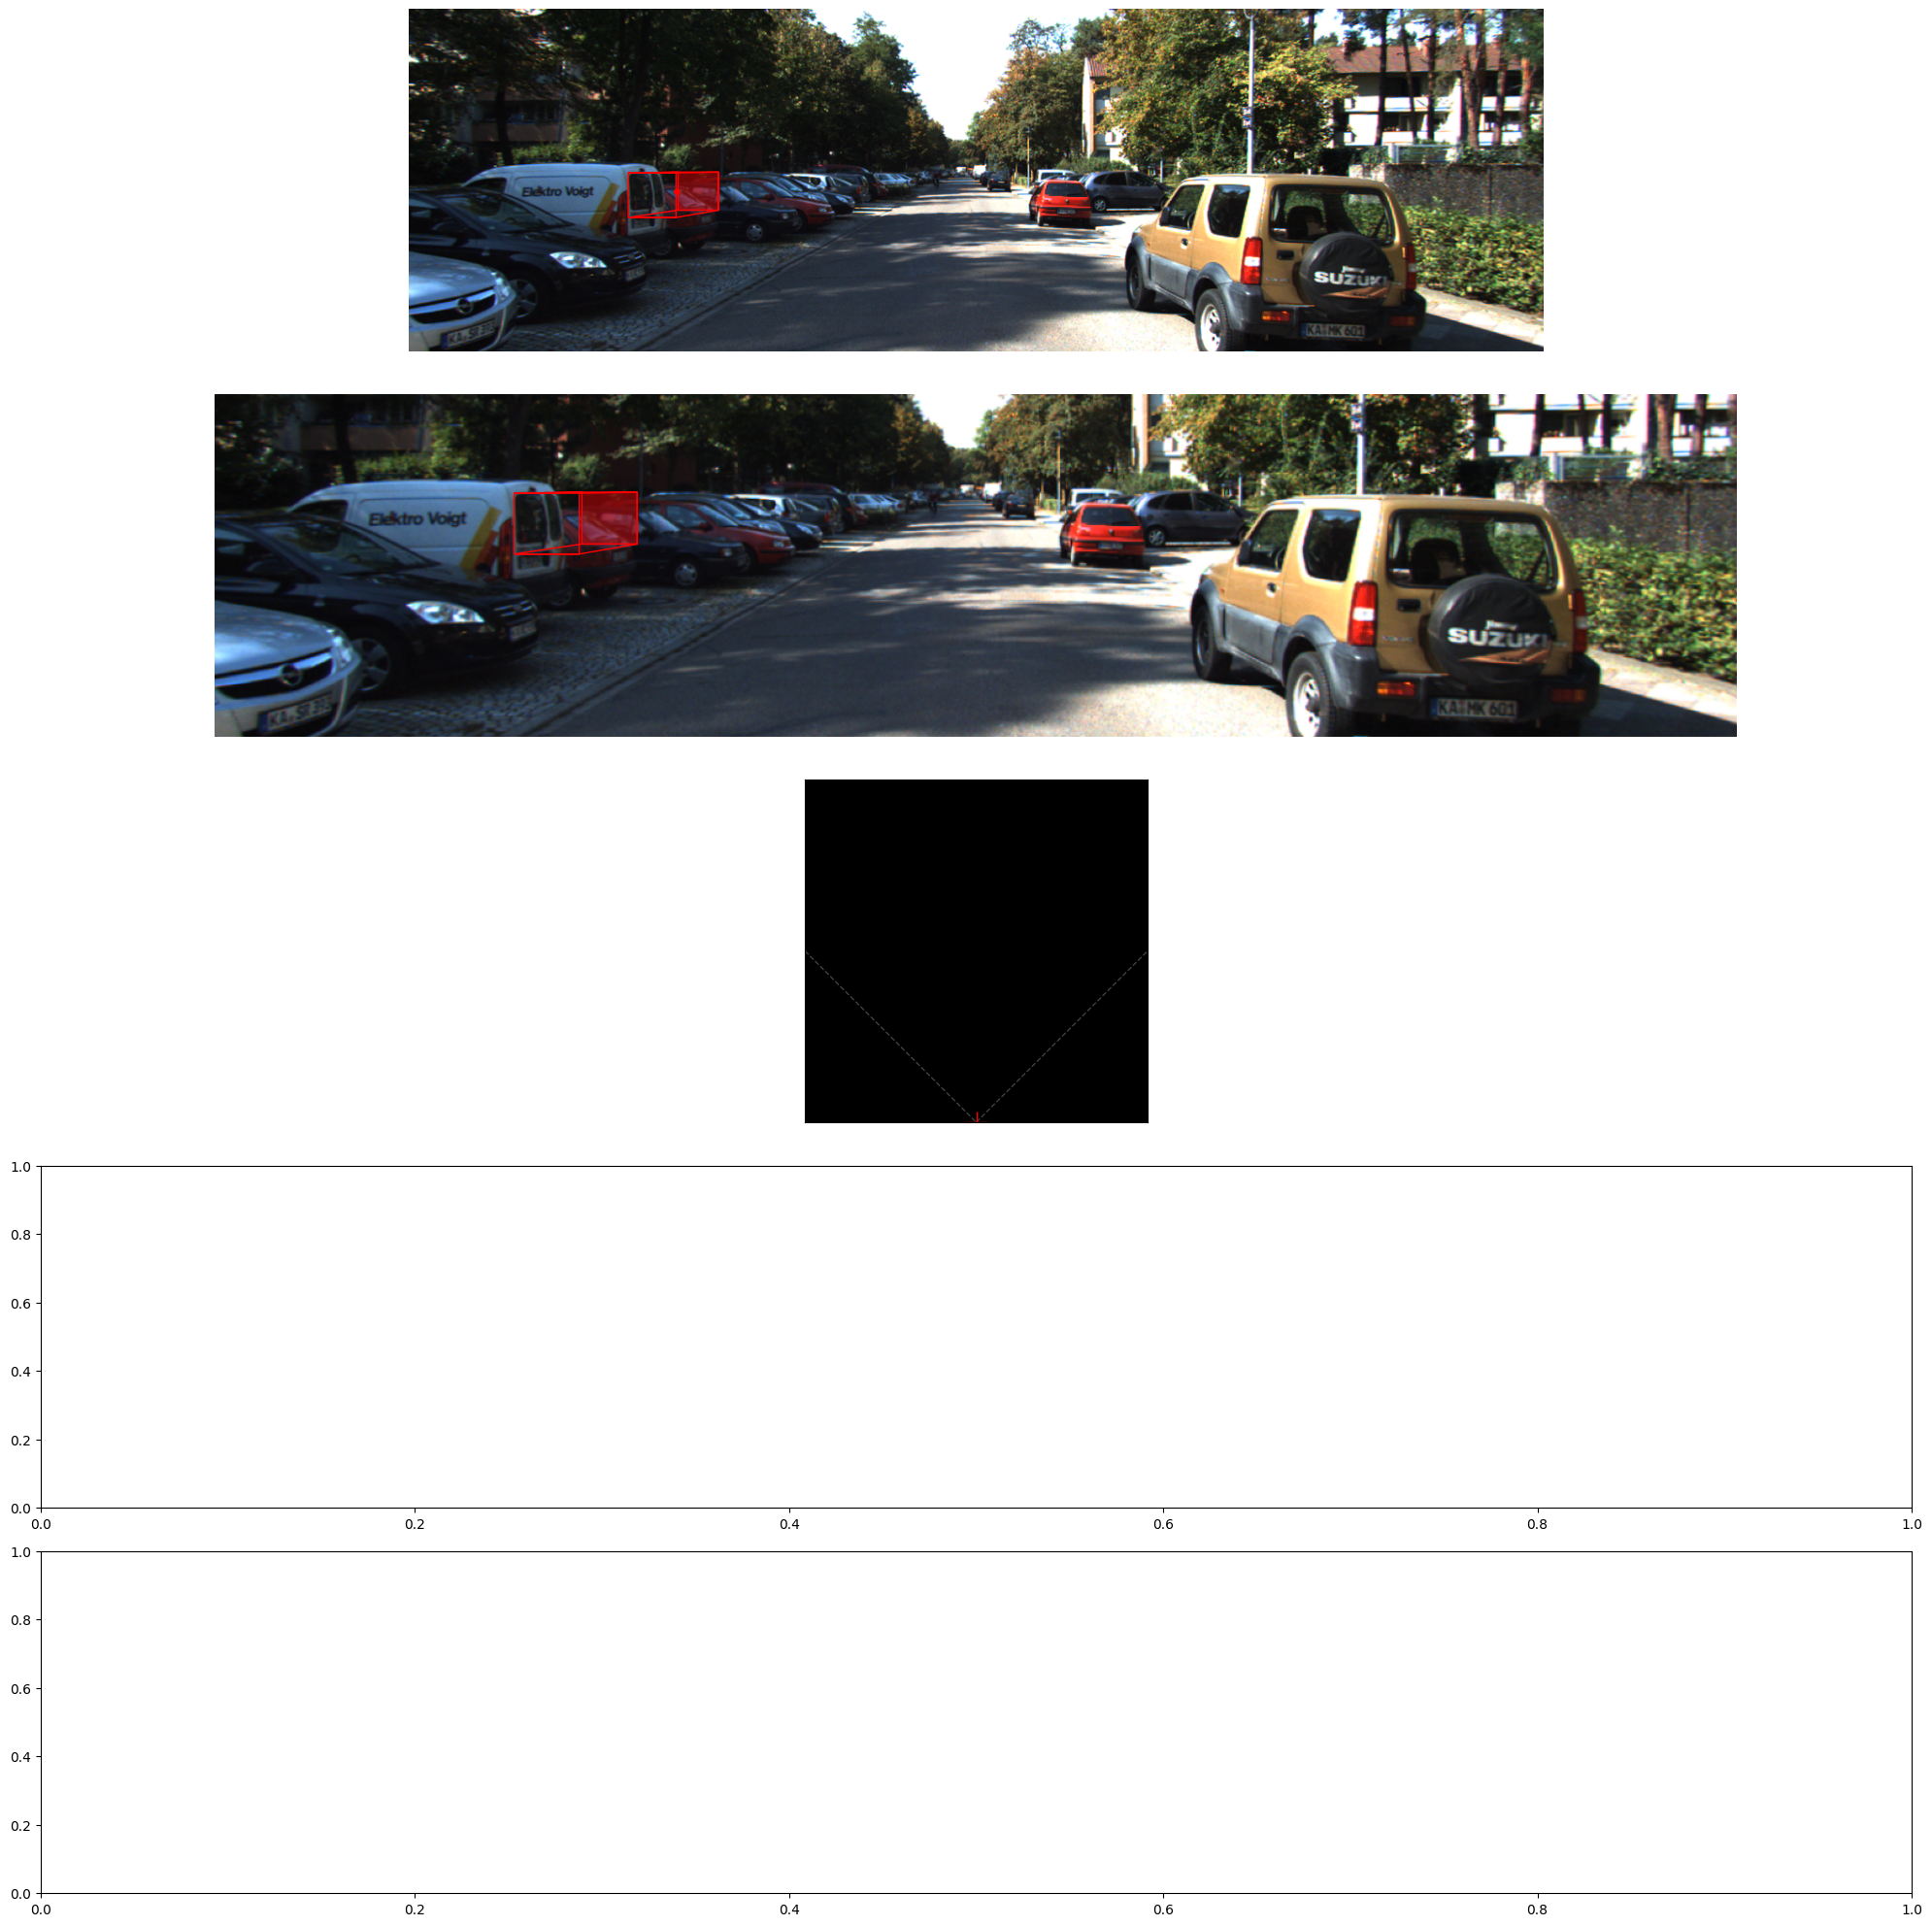

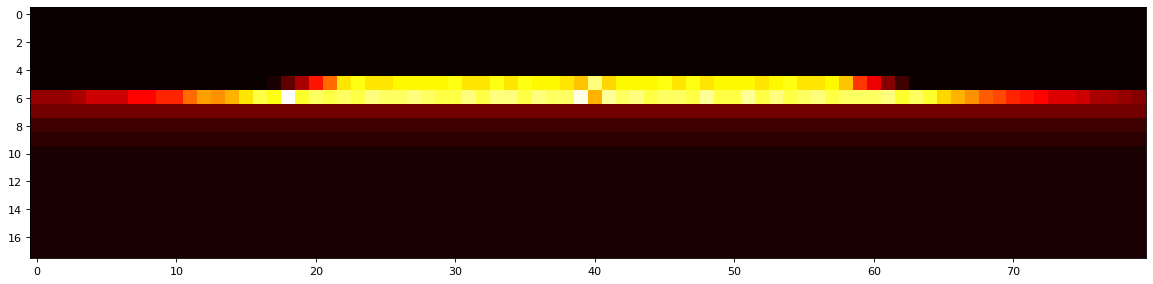

In [54]:
import sys
sys.path.insert(0, "../kitti/")
from util import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D
import matplotlib.pyplot as plt
import cv2
import numpy as np
from math import pi, atan2
from matplotlib.path import Path
import matplotlib.patches as patches
import copy
# 
# assume crop_top 100 pixel and resize into (288, 1280)
CROP_TOP = 100
img_new_h, img_new_w = (288, 1280) # img_new_h, img_new_w

# This script will generate 3D anchors based on my prior knowldged
img = cv2.imread("/home/lab530/KenYu/kitti/training/image_2/000169.png")
img_ori_h, img_ori_w, _ = img.shape
img_crp_h = img_ori_h - CROP_TOP

# Assuming croptop 100 pixel + resize into (288, 1280) - preservse aspect ratio
img_tf = cv2.resize(img[CROP_TOP:, :], (int(img_ori_w * img_new_h / img_crp_h), 
                                        int(img_crp_h * img_new_h / img_crp_h)))
# crop in
if img_tf.shape[1] > img_new_w:
    img_tf = img_tf[:, 0:img_new_w, :]
elif img_tf.shape[1] < img_new_w: # pad out
    img_tf = np.pad(img_tf,  [(0, 0), (0, img_new_w - img_tf.shape[1]), (0, 0)], 'constant')
# print(f"img_tf = {img_tf.shape}") # (288, 1280)

# All the image has the same P2
P2 = kitti_calib_file_parser("/home/lab530/KenYu/kitti/training/calib/000169.txt")

# Transform P2 calibration matrix
P2_tf = copy.deepcopy(P2)
# Crop Top 
P2_tf[1, 2] = P2_tf[1, 2] - CROP_TOP               # cy' = cy - dv
P2_tf[1, 3] = P2_tf[1, 3] - CROP_TOP * P2_tf[2, 3] # ty' = ty - dv * tz
# Resize (Preserved aspect ratio)
P2_tf[0, :] = P2_tf[0, :] * img_new_h / img_crp_h
P2_tf[1, :] = P2_tf[1, :] * img_new_h / img_crp_h

OUT_TXT = "/home/lab530/KenYu/ml_toolkit/anchor_generation/anchor.txt"
AVG_HEIGT = 1.526
AVG_WIDTH = 1.629
AVG_LENTH = 3.884

BEV_SHAPE = 900
BEV_SCALE = 15

def compute_birdviewbox(anchor):
    h = anchor.h * BEV_SCALE
    w = anchor.w * BEV_SCALE
    l = anchor.l * BEV_SCALE
    x = anchor.x3d * BEV_SCALE
    y = anchor.y3d * BEV_SCALE
    z = anchor.z3d * BEV_SCALE
    rot_y = anchor.rot_y

    R = np.array([[-np.cos(rot_y), np.sin(rot_y)],
                  [ np.sin(rot_y), np.cos(rot_y)]])
    t = np.array([x, z]).reshape(1, 2).T

    x_corners = [-l/2, l/2, l/2, -l/2]  # -l/2
    z_corners = [ w/2, w/2,-w/2, -w/2]  # -w/2

    # bounding box in object coordinate
    corners_2D = np.array([x_corners, z_corners])
    # rotate
    corners_2D = R.dot(corners_2D)
    # translation
    corners_2D = t - corners_2D
    # in camera coordinate
    corners_2D[0] += int(BEV_SHAPE/2)
    corners_2D = (corners_2D).astype(np.int16)
    corners_2D = corners_2D.T
    return np.vstack((corners_2D, corners_2D[0,:]))

def draw_birdeyes(ax, anchor, color = (1,0,0), title = "123"):
    gt_corners_2d = compute_birdviewbox(anchor)
    # Draw GT
    codes = [Path.LINETO] * gt_corners_2d.shape[0]
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    pth = Path(gt_corners_2d, codes)
    p = patches.PathPatch(pth, fill=False, color=color, label=title)
    ax.add_patch(p)

def draw_corner_2D(ax, corners_2D, color = (1,0,0)):
    # draw all lines through path
    # https://matplotlib.org/users/path_tutorial.html
    bb3d_lines_verts_idx = [0, 1, 2, 3, 4, 5, 6, 7, 0, 5, 4, 1, 2, 7, 6, 3]
    bb3d_on_2d_lines_verts = corners_2D[:, bb3d_lines_verts_idx]
    verts = bb3d_on_2d_lines_verts.T
    codes = [Path.LINETO] * verts.shape[0]
    codes[0] = Path.MOVETO

    pth = Path(verts, codes)
    p = patches.PathPatch(pth, fill=False, color=color, linewidth=1)
    ax.add_patch(p)

    # put a mask on the front
    width = corners_2D[:, 3][0] - corners_2D[:, 1][0]
    height = corners_2D[:, 2][1] - corners_2D[:, 1][1]
    front_fill = patches.Rectangle((corners_2D[:, 1]), width, height, fill=True, color=color, alpha=0.4)
    ax.add_patch(front_fill)

def draw_2Dbox(ax, corners, color = (1,0,0)):
    x1, y1, x2, y2 = corners
    width  = x2 - x1
    height = y2 - y1
    front_fill = patches.Rectangle((x1, y1),
                                    width, 
                                    height, 
                                    fill=False, 
                                    color=color, 
                                    linewidth=1,
                                    alpha=1)
    ax.add_patch(front_fill)

class Anchor():
    def __init__(self, x3d, y3d, z3d, rot_y, is_transform, dimension = (AVG_HEIGT, AVG_WIDTH, AVG_LENTH)):
        # Get P2
        if is_transform: self.P2 = P2_tf
        else: self.P2 = P2

        self.x3d = x3d # bottom face center
        self.y3d = y3d
        self.z3d = z3d
        self.h = dimension[0]
        self.w = dimension[1]
        self.l = dimension[2]
        self.rot_y = rot_y
        self.corner_2D = get_corner_2D(self.P2, (x3d, y3d, z3d), rot_y, (self.l, self.h, self.w))
        self.xmin = self.corner_2D[0].min()
        self.xmax = self.corner_2D[0].max()
        self.ymin = self.corner_2D[1].min()
        self.ymax = self.corner_2D[1].max()
        
        # Get observation angle: alpha
        self.alpha = rot_y + atan2(z3d, x3d) - pi/2
        
        # alpha in [-pi, pi]
        if   self.alpha >  pi: self.alpha -= 2*pi
        elif self.alpha < -pi: self.alpha += 2*pi

        # Get cx, cy, cz
        tmp = np.dot(self.P2, np.array([[x3d], [y3d - self.h/2], [z3d], [1]]))
        tmp[0:2] /= tmp[2]
        self.cx, self.cy, self.cz = float(tmp[0]), float(tmp[1]), float(tmp[2])

        # Get cx, cy in 18*80 feature map # I use cx,cy to define anchor's features
        self.cx_f_index = int(round(self.cx * (1/16)))
        self.cy_f_index = int(round(self.cy * (1/16)))
    
    def __str__(self):
        # Note that this function will output transformed 2D pixels
        return f"Car -1 -1 {round(self.alpha, 2)} {round(self.xmin, 2)} {round(self.ymin, 2)} {round(self.xmax, 2)} {round(self.ymax, 2)} {round(self.h, 2)} {round(self.w, 2)} {round(self.l, 2)} {round(self.x3d, 2)} {round(self.y3d, 2)} {round(self.z3d, 2)} {round(self.rot_y, 2)}\n"

class Label():
    def __init__(self, obj, is_transform):
        # Get P2
        if is_transform: self.P2 = P2_tf
        else: self.P2 = P2

        self.x3d = obj.x_3d # bottom face center
        self.y3d = obj.y_3d
        self.z3d = obj.z_3d
        self.h = obj.h
        self.w = obj.w
        self.l = obj.l
        self.rot_y = obj.rot_y
        self.corner_2D = get_corner_2D(self.P2, (obj.x_3d, obj.y_3d, obj.z_3d), obj.rot_y, (self.l, self.h, self.w))
        self.xmin = obj.x_min
        self.xmax = obj.x_max
        self.ymin = obj.y_min
        self.ymax = obj.y_max
        self.alpha = obj.alpha
        
        # Get cx, cy, cz
        tmp = np.dot(self.P2, np.array([[obj.x_3d], [obj.y_3d - self.h/2], [obj.z_3d], [1]]))
        tmp[0:2] /= tmp[2]
        self.cx, self.cy, self.cz = float(tmp[0]), float(tmp[1]), float(tmp[2])

        # Get cx, cy in 18*80 feature map # I use cx,cy to define anchor's features
        self.cx_f_index = int(round(self.cx * (1/16)))
        self.cy_f_index = int(round(self.cy * (1/16)))
    
    def __str__(self):
        # Note that this function will output transformed 2D pixels
        return f"Car -1 -1 {round(self.alpha, 2)} {round(self.xmin, 2)} {round(self.ymin, 2)} {round(self.xmax, 2)} {round(self.ymax, 2)} {round(self.h, 2)} {round(self.w, 2)} {round(self.l, 2)} {round(self.x3d, 2)} {round(self.y3d, 2)} {round(self.z3d, 2)} {round(self.rot_y, 2)}\n"

ANCHOR_X_STRIDE = 0.7
ANCHOR_Z_STRIDE = 1.5
ANCHOR_Y_3D     = 1.71

fig, ax = plt.subplots(5, 1, figsize=(20, 20))

# Generate anchor
# anchor = Anchor(2.76,  1.68, 6.69, -1.59)
# print(anchor.corner_2D)
# draw_corner_2D(ax[0], anchor.corner_2D)
# Car 0.17 0 -1.96 784.78 177.12 1124.16 374.00 1.62 1.48 3.36 2.76 1.68 6.69 -1.59

anchors = []
anchors_untransform = []

fy = P2_tf[1, 1]
# Get anchor_z_step
anchor_z_step = []
z1 = 80
v1 = (ANCHOR_Y_3D - AVG_HEIGT/2.0)*fy/z1
while v1 < 288:
    anchor_z_step.append(z1)
    dz = min(z1 - ( v1*z1 / (v1 + 16) ), ANCHOR_Z_STRIDE)
    z1 -= dz
    v1 = (ANCHOR_Y_3D - AVG_HEIGT/2.0)*fy/z1

# 
# Generate anchor by BEV view
# for z_3d in np.arange(80, 0.0, -anchor_z_step):

for z_3d in anchor_z_step:
    fx = P2_tf[0, 0]
    
    # Get anchor_x_stride
    anchor_x_stride = z_3d*16/fx
    anchor_x_stride = min(anchor_x_stride, ANCHOR_X_STRIDE)# Saturation anchor_x_stride

    for x_3d in np.arange(-30, 30.1, anchor_x_stride):
        for rot_y in [0, -pi/2]:
            anchor             = Anchor(x_3d, ANCHOR_Y_3D, z_3d, rot_y, is_transform=True)
            anchor_untransform = Anchor(x_3d, ANCHOR_Y_3D, z_3d, rot_y, is_transform=False)
            # TODO, truncated object might not able to be captured by anchors because its (cx, cy) is not in image
            if 0 <= anchor.cx_f_index < 80 and 0 <= anchor.cy_f_index < 18:
                anchors.append(anchor)
                anchors_untransform.append(anchor_untransform)
                # img = cv2.circle(img, (int(anchors[-1].cx), int(anchors[-1].cy)), radius=1, color=(0, 0, 255), thickness=1)
            # draw_corner_2D(ax[0], anchors[-1].corner_2D)
            # draw_2Dbox(ax[1], (anchors[-1].xmin, anchors[-1].ymin, anchors[-1].xmax, anchors[-1].ymax))
            # draw_birdeyes(ax[2], anchors[-1])
print(f"number of anchor in total = {len(anchors)}")

# Draw a specific anchor 
NUMBER = 6331

# Draw un-transform bbox
# draw_2Dbox(ax[0], (anchors[NUMBER].xmin, anchors[NUMBER].ymin, anchors[NUMBER].xmax, anchors[NUMBER].ymax))
draw_corner_2D(ax[0], anchors_untransform[NUMBER].corner_2D)
img = cv2.circle(img, (int(anchors_untransform[NUMBER].cx), int(anchors_untransform[NUMBER].cy)), radius=2, color=(0, 0, 255), thickness=2)

# Draw transformed bbox
draw_corner_2D(ax[1], anchors[NUMBER].corner_2D)

# Draw center point of bbox
# img_tf = cv2.circle(img_tf, (int(anchors[NUMBER].cx), int(anchors[NUMBER].cy)), radius=2, color=(0, 0, 255), thickness=2)

heat_data = np.zeros(shape=(18, 80))
for anchor in anchors:
    if 0 <= anchor.cx_f_index < 80 and 0 <= anchor.cy_f_index < 18:
        heat_data[anchor.cy_f_index, anchor.cx_f_index] += 1

print(f"Most concentrated features pixel has {heat_data.max()} anchors" )
print(f"Total anchor in heatmap = {heat_data.sum()}")
print(f"There are {18*80 - np.count_nonzero(heat_data)} pixel that don't have anchors")

plt.figure(figsize=(18, 80), dpi=80)
plt.imshow(heat_data, cmap='hot', interpolation='nearest')

# Visualize BEV
birdimage = np.zeros((BEV_SHAPE, BEV_SHAPE, 3), np.uint8)
# plot camera view range
x1 = np.linspace(0, BEV_SHAPE/2)
x2 = np.linspace(BEV_SHAPE/2, BEV_SHAPE)
ax[2].plot(x1, BEV_SHAPE / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
ax[2].plot(x2, x2 - BEV_SHAPE / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
ax[2].plot(BEV_SHAPE / 2, 0, marker='+', markersize=16, markeredgecolor='red')
ax[2].imshow(birdimage, origin='lower')
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.set_facecolor('white')
fig.tight_layout()
ax[0].axis('off')
ax[0].imshow(img[...,::-1])
ax[1].axis('off') 
ax[1].imshow(img_tf[...,::-1])


## Output anchor to txt file(kitti label format)

In [55]:
with open(OUT_TXT, 'w') as f: 
    for anchor in anchors:
        f.write(anchor.__str__())
print(f"Write anchor result to {OUT_TXT}")

import pickle
import torch
# Anchor to [N, 12] format
# sampled_gt_bboxes = [x1, y1, x2, y2, cls_index, cx, cy , cz, w, h, l , alpha, x3d, y3d, z3d, rot_y]
#                       0  1   2   3   4          5   6    7   8  9  10, 11   , 12   ,13, 14 , 15
# Convert anchor to tensor 
anchors_tensor = []
for a in anchors:
    anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, 
                           a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
                           a.x3d, a.y3d, a.z3d, a.rot_y])
anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]

with open("anchors.pkl", 'wb') as f:
    pickle.dump(anchors_tensor, f)
print(f"Write anchor result to anchor.pkl")

with open("anchor_distribution.pkl", 'wb') as f:
    pickle.dump(heat_data, f)
print(f"Write anchor result to anchor_distribution.pkl")



Write anchor result to /home/lab530/KenYu/ml_toolkit/anchor_generation/anchor.txt
anchors_tensor.shape = torch.Size([9332, 16])
Write anchor result to anchor.pkl
Write anchor result to anchor_distribution.pkl


# Is all calib txt the same? Yes

In [56]:
# # Answer: yes, they are all the same

# import os
# P2 = None 
# for fn in os.listdir("/home/lab530/KenYu/kitti/training/calib/"):
#     if P2 != None: 
#         P2_tmp = kitti_calib_file_parser(f"/home/lab530/KenYu/kitti/training/calib/{fn}")
#         if P2_tmp != P2: 
#             print(P2)
#             print(P2_tmp)
#             P2 = P2_tmp


# Anchor assigment


Car 0.17 0 -1.96 784.78 177.12 1124.16 374.00 1.62 1.48 3.36 2.76 1.68 6.69 -1.59
2D bbox original = (784, 177, 1124, 374)
2D bbox transformed = (array([821.06181818]), array([80.64]), array([1177.13454545]), array([286.95272727]))
label 2dbox project by 3d bbox = tensor([[ 784.,  177., 1124.,  374.]])
n_pos = 4


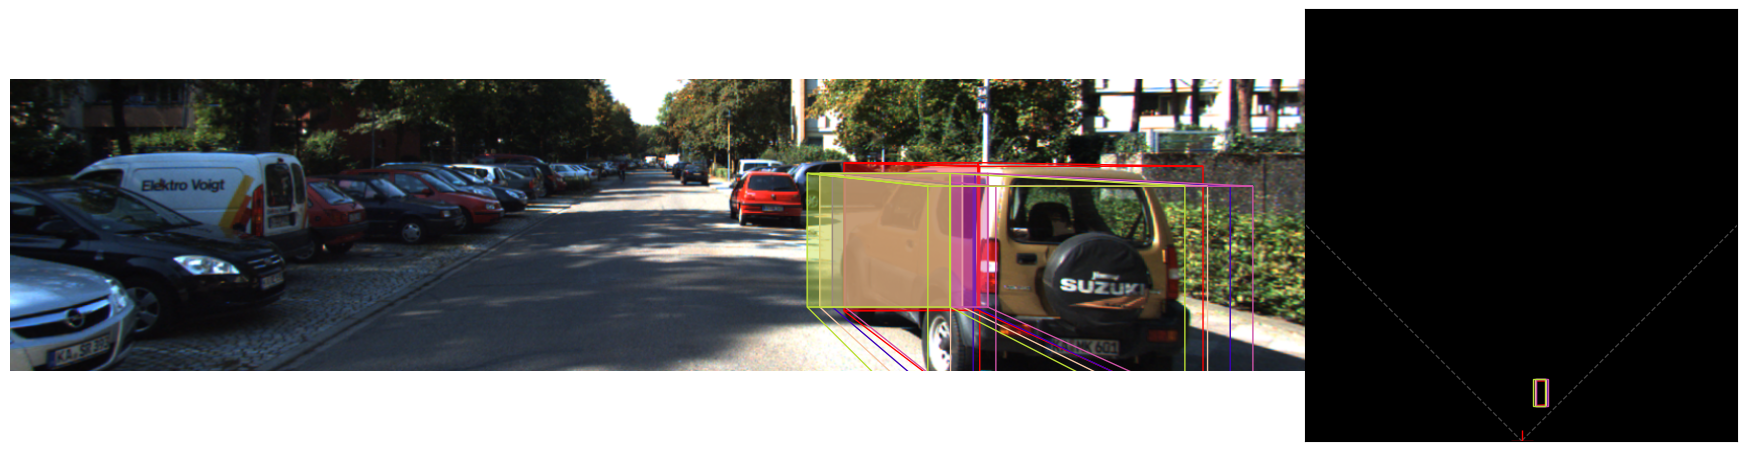

In [57]:
import torch
labels = kitti_label_file_parser("/home/lab530/KenYu/kitti_anchor_gen/training/label_2/000169.txt")
        
LABEL_NUMBER = 0 # [3015, 3017, 3019, 3021, 6487, 6585, 6587, 6589, 7102, 7129, 7140, 7142, 7163, 7165, 7167, 7172] # 0 # 12
print(labels[LABEL_NUMBER].__str__())
label = Label(labels[LABEL_NUMBER], is_transform = True)

# label = Anchor(labels[LABEL_NUMBER].x_3d, labels[LABEL_NUMBER].y_3d, labels[LABEL_NUMBER].z_3d, labels[LABEL_NUMBER].rot_y, is_transform = True)

T = np.identity(3)
# Crop Top 
T[1, 2] = T[1, 2] - CROP_TOP # cy' = cy - dv
# Resize (Preserved aspect ratio)
T[0, :] = T[0, :] * img_new_h / img_crp_h
T[1, :] = T[1, :] * img_new_h / img_crp_h

x1_tf, y1_tf = ( T @ np.array([[labels[0].x_min], [labels[0].y_min], [1]]) )[:2]
x2_tf, y2_tf = ( T @ np.array([[labels[0].x_max], [labels[0].y_max], [1]]) )[:2]

print( f"2D bbox original = { (labels[0].x_min, labels[0].y_min, labels[0].x_max, labels[0].y_max)}")
print( f"2D bbox transformed = { (x1_tf, y1_tf, x2_tf, y2_tf) }")

def calc_iou(a, b):
    """
    This is from GAC code
    Calculate 2D iou between two bounding box
    INput: 
        a - [:, 4] - x1, y1, x2, y2
    """

    # Get area of bounding boxes
    a_area = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    b_area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    # Get Intersection
    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])
    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)
    intersection = iw * ih

    # Get Union
    union = torch.unsqueeze(a_area, dim=1) + b_area - intersection
    union = torch.clamp(union, min=1e-8)
    
    # Get IoU
    IoU = intersection / union

    return IoU

# Convert label to tensor 
labels_tensor = torch.FloatTensor([[label.xmin, label.ymin, label.xmax, label.ymax]])
print(f"label 2dbox project by 3d bbox = {labels_tensor}") # Should be (821.8786909090909, 80.76567272727274, 1177.3021090909092, 286.9527272727273)

# # anchor assignment via IOU
# IoU = calc_iou(anchors_tensor, labels_tensor) # IoU = [14284, 1]
# # Find max overlap groundture with the anchor
# iou_max, iou_argmax = IoU.max(dim=1) # [14284], [14284]
# BG_IOU_THRES = 0.4
# FG_IOU_THRES = 0.5
# # Anchor Assignment
# anchor_assignment = iou_argmax.new_full((iou_argmax.shape[0], ), -2, dtype=torch.long)
# # Assign positive anchor
# anchor_assignment[iou_max >= FG_IOU_THRES] = iou_argmax[iou_max >= FG_IOU_THRES]
# # Assign negative anchor
# anchor_assignment[iou_max <  BG_IOU_THRES] = -1

# # Anchor assignment via Norm_1 
norm_1 = abs(anchors_tensor[:, 12] - label.x3d) + abs(anchors_tensor[:, 14] - label.z3d)
norm_1[ torch.abs(torch.cos(anchors_tensor[:, 15] - label.rot_y)) < pi/4 ] = float('inf')
values, indexes = torch.topk(norm_1, 4, largest=False)
pos_inds = indexes

# Get index of postive and negative anchor
# pos_inds = torch.nonzero(anchor_assignment >= 0, as_tuple=False).squeeze()
# neg_inds = torch.nonzero(anchor_assignment ==-1, as_tuple=False).squeeze()

n_pos = pos_inds.shape[0]
# n_neg = neg_inds.shape[0]

print(f"n_pos = {n_pos}")
# print(f"n_neg = {n_neg}")

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 15), dpi=100)
plt.subplots_adjust(wspace=0, hspace=0)

gs = GridSpec(2, 4)
gs.update(wspace=0)  # set the spacing between axes.
ax_img = fig.add_subplot(gs[0, :3])
ax_bev = fig.add_subplot(gs[0,  3])

# Draw ground true 3d bbox
draw_corner_2D(ax_img, label.corner_2D,  color = (1,0,0))
draw_birdeyes(ax_bev, label, color = (1,0,0))

import random
for i in range(n_pos):
    # draw_2Dbox(ax[0], tuple(anchors_tensor[ pos_inds[i], :4].numpy()), color=(0,0,1) )

    color = (random.random(), random.random(), random.random())
    draw_corner_2D(ax_img, anchors[pos_inds[i]].corner_2D, color = color)
    draw_birdeyes(ax_bev, anchors[pos_inds[i]], color = color)

fig.set_facecolor('white')
fig.tight_layout()

# Visualize BEV
# plot camera view range
BEV_SHAPE = 900
x1 = np.linspace(0, BEV_SHAPE/2)
x2 = np.linspace(BEV_SHAPE/2, BEV_SHAPE)
ax_bev.plot(x1, BEV_SHAPE / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev.plot(x2, x2 - BEV_SHAPE / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev.plot(BEV_SHAPE / 2, 0, marker='+', markersize=16, markeredgecolor='red')
ax_bev.imshow(np.zeros((BEV_SHAPE, BEV_SHAPE, 3), np.uint8), origin='lower')
ax_bev.set_xticks([])
ax_bev.set_yticks([])

ax_img.axis('off')
ax_img.imshow(img_tf[...,::-1])



# Draw anchor from GAC

n_pos_my = 16


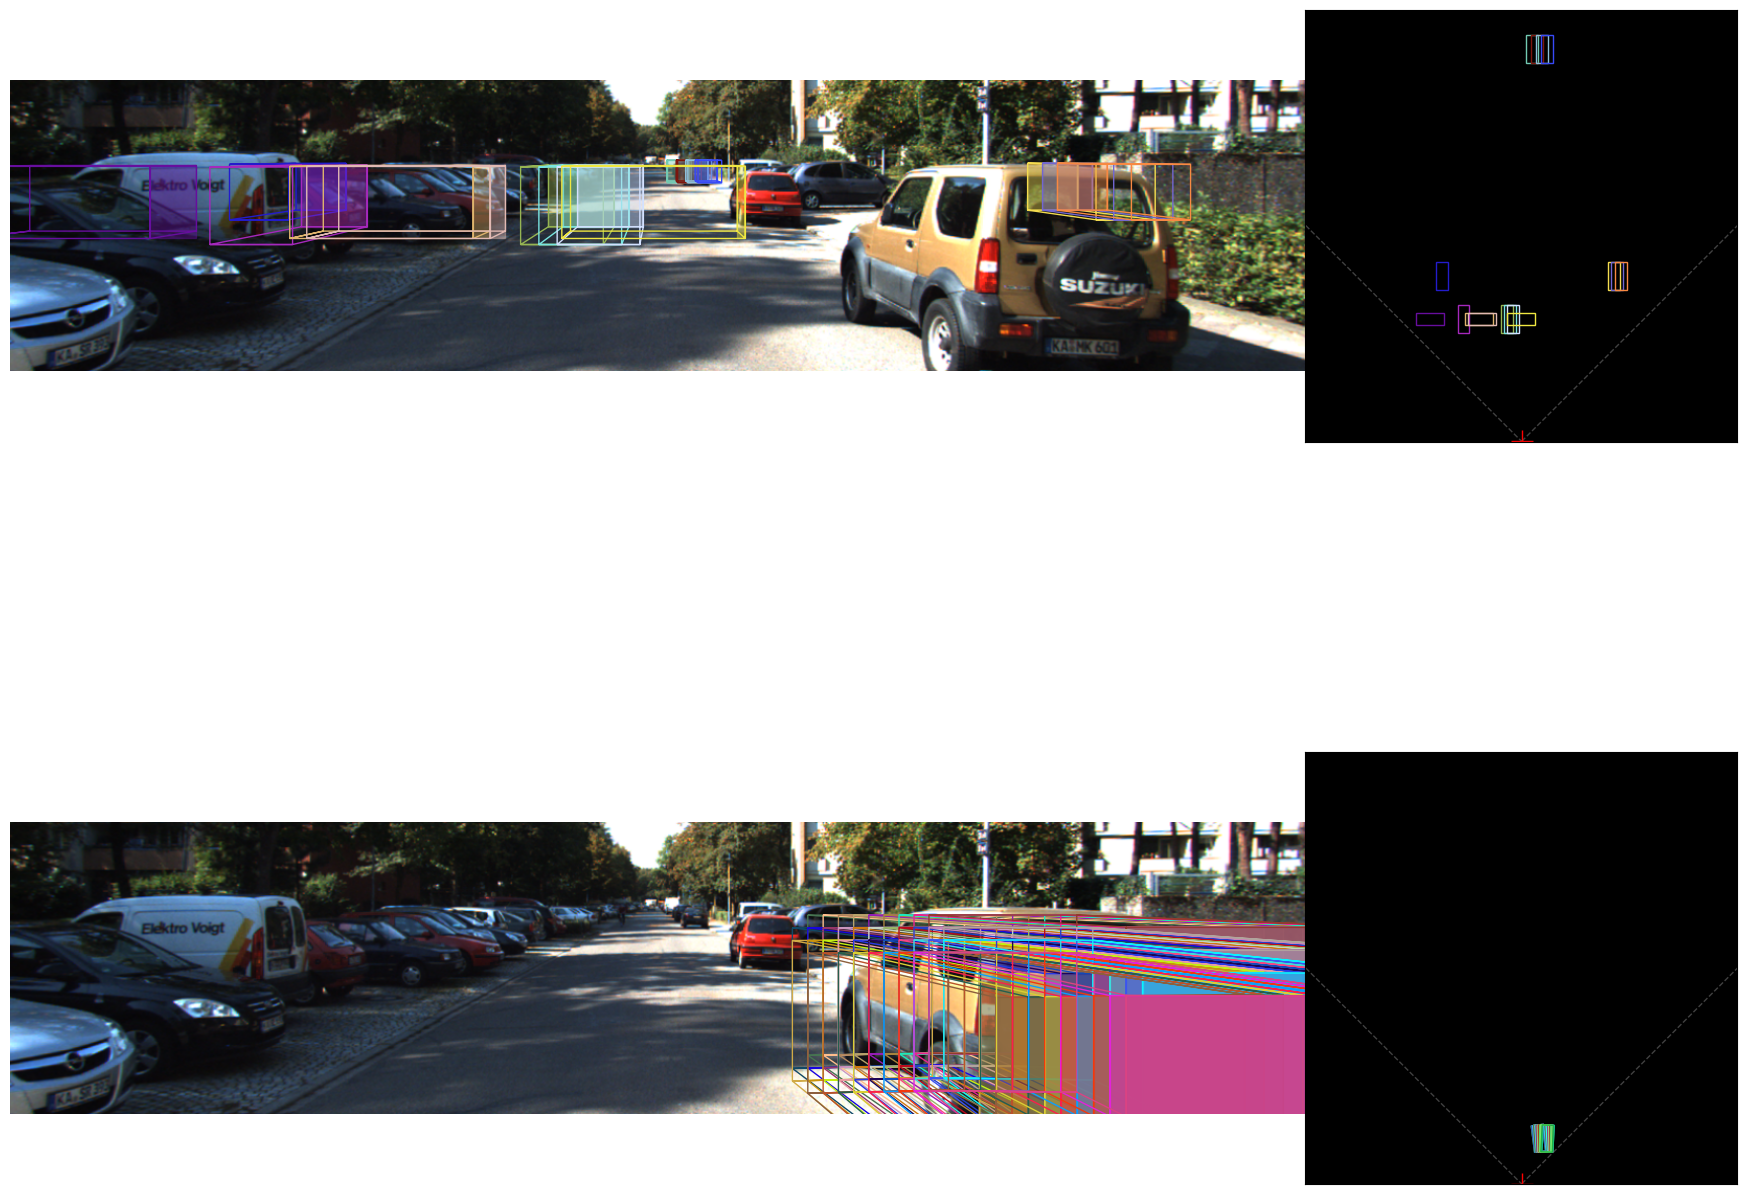

In [58]:
import torch
from matplotlib.gridspec import GridSpec

# Load my anchor
pos_inds_my = torch.tensor([3015, 3017, 3019, 3021, 6487, 6585, 6587, 6589, 7102, 7129, 7140, 7142, 7163, 7165, 7167, 7172])
n_pos_my = pos_inds_my.shape[0]
print(f"n_pos_my = {n_pos_my}")

# Load GAC's anchor
import pickle
with open("/home/lab530/KenYu/visualDet3D/GAC_head_anchor_2D.pkl", 'rb') as f:
    GAC_head_anchor_2D = pickle.load(f) 
with open("/home/lab530/KenYu/visualDet3D/GAC_head_anchor_3D.pkl", 'rb') as f:
    GAC_head_anchor_3D = pickle.load(f)
# pickle.load()


fig = plt.figure(figsize=(18, 15), dpi=100)
plt.subplots_adjust(wspace=0, hspace=0)

gs = GridSpec(2, 4)
gs.update(wspace=0)  # set the spacing between axes.
ax_img_my = fig.add_subplot(gs[0, :3])
ax_bev_my = fig.add_subplot(gs[0,  3])
ax_img_gac = fig.add_subplot(gs[1, :3])
ax_bev_gac = fig.add_subplot(gs[1,  3])

import random
for i in range(n_pos_my):
    color = (random.random(), random.random(), random.random())
    draw_corner_2D(ax_img_my, anchors[pos_inds_my[i]].corner_2D, color = color)
    draw_birdeyes(ax_bev_my, anchors[pos_inds_my[i]], color = color)

# Draw GAC anchors 
import random
for i in range(GAC_head_anchor_2D.shape[0]):
    color = (random.random(), random.random(), random.random())
    
    cx = (GAC_head_anchor_2D[i, 2] + GAC_head_anchor_2D[i, 0]) / 2.0
    cy = (GAC_head_anchor_2D[i, 3] + GAC_head_anchor_2D[i, 1]) / 2.0
    cz =  GAC_head_anchor_3D[i, 0, 0]
    # print(f"(cx, cy, cz) = {np.array([[cx], [cy], [cz]])}")

    loc_3d = np.linalg.inv(P2_tf[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
    loc_3d[1, 0] += GAC_head_anchor_3D[i, 4, 0] / 2.0

    # Get observation angle: alpha
    alpha = atan2(GAC_head_anchor_3D[i, 1, 0], GAC_head_anchor_3D[i, 2, 0]) / 2.0
    rot_y = alpha - atan2(loc_3d[2, 0], loc_3d[0, 0]) + pi/2
    
    # alpha in [-pi, pi]
    if   rot_y >  pi: rot_y -= 2*pi
    elif rot_y < -pi: rot_y += 2*pi

    corner_2D = get_corner_2D(P2_tf, (loc_3d[0, 0], loc_3d[1, 0], loc_3d[2, 0]),
                                rot_y,
                                (GAC_head_anchor_3D[i, 5, 0], 
                                 GAC_head_anchor_3D[i, 4, 0], 
                                 GAC_head_anchor_3D[i, 3, 0]))
    # print(f"loc_3d = {loc_3d}")
    dimension = (GAC_head_anchor_3D[i, 4, 0], GAC_head_anchor_3D[i, 3, 0], GAC_head_anchor_3D[i, 5, 0])
    a = Anchor(loc_3d[0, 0], loc_3d[1, 0], loc_3d[2, 0], rot_y, True, dimension = dimension)

    draw_corner_2D(ax_img_gac, corner_2D, color = (random.random(), random.random(), random.random()))
    draw_birdeyes (ax_bev_gac, a, color = color)

fig.set_facecolor('white')
fig.tight_layout()

# Visualize BEV
# plot camera view range
BEV_SHAPE = 900
x1 = np.linspace(0, BEV_SHAPE/2)
x2 = np.linspace(BEV_SHAPE/2, BEV_SHAPE)
ax_bev_my.plot(x1, BEV_SHAPE / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_my.plot(x2, x2 - BEV_SHAPE / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_my.plot(BEV_SHAPE / 2, 0, marker='+', markersize=16, markeredgecolor='red')
ax_bev_my.imshow(np.zeros((BEV_SHAPE, BEV_SHAPE, 3), np.uint8), origin='lower')
ax_bev_my.set_xticks([])
ax_bev_my.set_yticks([])

ax_img_my.axis('off')
ax_img_my.imshow(img_tf[...,::-1])

############################################

ax_bev_gac.plot(x1, BEV_SHAPE / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_gac.plot(x2, x2 - BEV_SHAPE / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_gac.plot(BEV_SHAPE / 2, 0, marker='+', markersize=16, markeredgecolor='red')
ax_bev_gac.imshow(np.zeros((BEV_SHAPE, BEV_SHAPE, 3), np.uint8), origin='lower')
ax_bev_gac.set_xticks([])
ax_bev_gac.set_yticks([])

ax_img_gac.axis('off')
ax_img_gac.imshow(img_tf[...,::-1])
